# Tarea 1: Activaciones y pasada hacia adelante en una red neuronal <br/> CC6204 Deep Learning, Universidad de Chile  <br/> Hoja de respuestas
## Nombre: José Rubio
Fecha de entrega: 2 de octubre de *2020*

In [ ]:
# Este notebook está pensado para correr en CoLaboratory. 
# Lo único imprescindible por importar es torch 
import torch

# Posiblemenete quieras instalar e importar ipdb para debuggear.
# Si es así, descomenta lo siguiente
# !pip install -q ipdb
# import ipdb

# Aqui instalamos la libreria de correccion del curso
!pip install "git+https://github.com/dccuchile/CC6204.git@master#egg=cc6204&subdirectory=autocorrect"

In [ ]:
# importamos las herramientas del curso
from cc6204 import AutoCorrect, FailedTest

# ingresa el host y port que posteamos en u-cursos

corrector = AutoCorrect(host='cc6204.dcc.uchile.cl', port=443)

# anota el token que te daremos en u-cursos

token = ']ye/Ox;nsz'

Connection stablished


# Parte 1: Funciones de activación y función de salida

## 1a) Funciones de activación

In [ ]:
def sig(T):
  return torch.reciprocal(1 + torch.exp(-1 * T))

def tanh(T):
  E = torch.exp(T)
  e = torch.exp(-1 * T)
  return (E - e) * torch.reciprocal(E + e)

# Tu código acá
def relu(T):
  T = torch.tensor(T)
  return (T + torch.abs(T))/(2)

def swish(T, beta):
  T = torch.tensor(T)
  return T*sig(beta*T)

def celu(T, alpha):
  T = torch.tensor(T)
  only_negative = (T - torch.abs(T))/(2)
  return (T + torch.abs(T))/(2) + (alpha*(torch.exp(only_negative/alpha)-1))

In [ ]:
# Tests del API del curso
test_relu = corrector.get_test_data(homework=1, question="1a", test=1, token=token)
test_swish, swish_par = corrector.get_test_data(homework=1, question="1a", test=2, token=token)
test_celu, celu_par = corrector.get_test_data(homework=1, question="1a", test=3, token=token)

# probablemente quieras convertr los variables test_* a un tensor, ya que por defecto son listas

corrector.sumbit(homework=1, question="1a", test=1, token=token, answer=relu(test_relu))
corrector.sumbit(homework=1, question="1a", test=2, token=token, answer=swish(test_swish, swish_par))
corrector.sumbit(homework=1, question="1a", test=3, token=token, answer=celu(test_celu, celu_par))

Correct Test!
Correct Test!
Correct Test!


## 1b) Softmax

###Demostración de invariabilidad del resultado de *softmax* al restarle el mismo elemento a todas las variables de un arreglo.

Anotando la definición de la función, entonces se debe demostrar la siguiente igualdad:

$\frac{e^{x_{i}}}{\sum_{j=1}^{N}e^{x_{j}}} = \frac{e^{x_{i}-c}}{\sum_{j=1}^{N}e^{x_{j}-c}}$

Desarrollando el lado derecho, se tiene que por propiedad de las exponenciales, la suma de exponentes equivale al producto de potencias de la misma base. Entonces:

$\frac{e^{x_{i}-c}}{\sum_{j=1}^{N}e^{x_{j}-c}} = \frac{e^{-c}e^{x_{i}}}{\sum_{j=1}^{N}e^{-c}e^{x_{j}}}$

En el denominador se tiene un producto entre una constante y la exponencial de la variable, por lo que por propiedad de la sumatoria se puede sacar de esta. Por ende:

$\frac{e^{-c}e^{x_{i}}}{\sum_{j=1}^{N}e^{-c}e^{x_{j}}} = \frac{\not{e^{-c}}e^{x_{i}}}{\not{e^{-c}}\sum_{j=1}^{N}e^{x_{j}}} = \frac{e^{x_{i}}}{\sum_{j=1}^{N}e^{x_{j}}}$

Con lo que el resultado de la función softmax no varia si se quita el mismo elemento a todo el arreglo.

In [ ]:
# Tu código acá

def softmax(T, dim, estable=True):
  T = torch.tensor(T, dtype=torch.float32)
  if estable:
    T_max = torch.max(T, dim=dim, keepdim=True)
    T = torch.exp(T-T_max[0])
    T_sum = torch.sum(T, dim=dim, keepdim=True, dtype=torch.float32)
    return (T)/(T_sum)
  else:
    T = torch.exp(T)
    T_sum = torch.sum(T, dim, keepdim=True, dtype=torch.float32)
    return (T)/(T_sum)

In [ ]:
# Tests del API del curso
test_softmax, _dim = corrector.get_test_data(homework=1, question="1b", test=1, token=token)
corrector.sumbit(homework=1, question="1b", test=1, token=token, answer=softmax(test_softmax, dim=_dim))

Correct Test!


# Parte 2: Red neuronal y pasada hacia adelante (forward)

## 2a) Clase para red neuronal, 2b) Iterando por parametros, 2d) Pasada hacia adelante

In [ ]:
# Tu código debiera continuar así 

class FFNN(torch.nn.Module):
  def __init__(self, F, l_h, l_a, C, bias, W, B, U, C_pre_trained, device):
    super(FFNN, self).__init__()
    self.F = torch.nn.Parameter(torch.rand(F,dtype=torch.float32))
    self.l_h = torch.nn.ParameterList([torch.nn.Parameter(torch.rand(i,dtype=torch.float32)) for i in l_h])
    self.bias = torch.nn.ParameterList([torch.nn.Parameter(torch.zeros(k,dtype=torch.float32)) for k in l_h])
    self.l_a = l_a
    self.C = torch.nn.Parameter(torch.rand(C,dtype=torch.float32))
    self.W = torch.nn.ParameterList([torch.nn.Parameter(j) for j in W])
    self.B = torch.nn.ParameterList([torch.nn.Parameter(l) for l in B])
    self.U = torch.nn.Parameter(U)
    self.C_pre_trained = torch.nn.Parameter(C_pre_trained)
    self.device = device
  
  def resumen(self):
    # Usa self.parameters() o self.named_parameters().
    return self.parameters()
  
  def forward_random_init(self, x):
    # Usa los parámetros y funciones de activación.
    # El valor de retorno debiera ser y = softmax(capa_de_salida).
    functions = self.l_a
    hiddens = self.l_h
    x_size = x.size()
    if len(x_size) <= 2: # En caso de se estuviese evaluando con un conjunto de muestras.
      B, features = x_size
      h = x
    elif len(x_size) == 3:
      B, features = x_size[0], x_size[1]*x_size[2]
      h = torch.reshape(x, (B,features))
    for hidden, activation in enumerate(functions):
      # Extendiendo las capas para redimensionar y que las multiplicaciones matriciales queden bien definidas.
      w = hiddens[hidden]
      h_prev_size, w_size = h.size()[1], w.size()[0]
      w = w.expand(h_prev_size, w_size)
      h = activation(h @ w + self.bias[hidden])
    C = self.C
    h_size, C_size = h.size()[1], C.size()[0]
    U = C.expand(h_size, C_size)
    # soft = torch.nn.Softmax(dim=1)
    # y_pred = soft(h @ U + C)
    y_pred = softmax(h @ U + C, dim=1)
    return y_pred
  
  def forward(self, x, predict=False):
    # Usa los parámetros y funciones de activación.
    # El valor de retorno debiera ser y = softmax(capa_de_salida).
    functions = self.l_a
    hiddens = self.W
    x_size = x.size()
    if len(x_size) <= 2: # En caso de se estuviese evaluando con un conjunto de muestras.
      B, features = x_size
      h = x
    elif len(x_size) == 3:
      B, features = x_size[0], x_size[1]*x_size[2]
      h = torch.reshape(x, (B, features))
    elif len(x_size) == 4:
      B, features = x_size[0], x_size[1]*x_size[2]*x_size[3]
      h = torch.reshape(x, (B, features))
    for hidden, activation in enumerate(functions):
      # Extendiendo las capas para redimensionar y que las multiplicaciones matriciales queden bien definidas.
      w = hiddens[hidden]
      if self.device == 'cpu':
        h = h.cpu()
        w = w.cpu()
      elif self.device == 'cuda':
        h = h.cuda()
        w = w.cuda()
      h = activation(h @ w + self.B[hidden])
    C = self.C_pre_trained
    U = self.U
    # soft = torch.nn.Softmax(dim=1)
    # y_pred = soft(h @ U + C)
    y_pred = softmax(h @ U + C, dim=1)
    if predict:
      y_pred = torch.reshape(torch.argmax(y_pred, dim=1),(B,))
      # y_pred = arg_pred.numpy()
      return y_pred
    else:
      return y_pred

## 2c) Moviendo los parámetros entre dispositivos

In [ ]:
# Tu código acá
# Se inventaron estos vectores solamente para analizar en donde estan siendo asignados los vectores al momento de inicializar la red.
W1 = torch.rand([4,5])
W2 = torch.rand([4,5])
b1 = torch.rand([4,5])
b2 = torch.rand([4,5])
U = torch.rand([4,5])
C = torch.rand([4,5])
FNN_test = FFNN(F=5, l_h=[32,16], l_a=[relu,relu], C=10, bias=0, W=[W1,W2], B=[b1,b2], U=U, C_pre_trained=C, device='cuda')
FNN_test.cuda()

FFNN(
  (l_h): ParameterList(
      (0): Parameter containing: [torch.cuda.FloatTensor of size 32 (GPU 0)]
      (1): Parameter containing: [torch.cuda.FloatTensor of size 16 (GPU 0)]
  )
  (bias): ParameterList(
      (0): Parameter containing: [torch.cuda.FloatTensor of size 32 (GPU 0)]
      (1): Parameter containing: [torch.cuda.FloatTensor of size 16 (GPU 0)]
  )
  (W): ParameterList(
      (0): Parameter containing: [torch.cuda.FloatTensor of size 4x5 (GPU 0)]
      (1): Parameter containing: [torch.cuda.FloatTensor of size 4x5 (GPU 0)]
  )
  (B): ParameterList(
      (0): Parameter containing: [torch.cuda.FloatTensor of size 4x5 (GPU 0)]
      (1): Parameter containing: [torch.cuda.FloatTensor of size 4x5 (GPU 0)]
  )
)

# Parte 3: Probando tu red con parámetros pre-entrenados para MNIST

In [ ]:
# Importamos MNIST desde torchvision.
from torchvision.datasets import MNIST

# Importamos una función para convertir imágenes en tensores.
from torchvision.transforms import ToTensor

# Importamos funcionalidades útiles para mirar los datos.
from matplotlib.pyplot import subplots
from random import randint

# Descarga y almacena el conjunto de prueba de MNIST.
dataset = MNIST('mnist', train=False, transform=ToTensor(), download=True)
print('Cantidad total de datos:',len(dataset))

Cantidad total de datos: 10000


In [ ]:
T, l = dataset[0]

print('Tensor')
print('tipo:', T.type())
print('dimensiones:', T.size())
print()
print('Entero')
print('valor:', l)

Tensor
tipo: torch.FloatTensor
dimensiones: torch.Size([1, 28, 28])

Entero
valor: 7


## 3b) Cargando los parámetros pre-entrenados

In [ ]:
# Tu código acá
from numpy import loadtxt
W1 = torch.from_numpy(loadtxt('W1.txt')).float()
W2 = torch.from_numpy(loadtxt('W2.txt')).float()
U = torch.from_numpy(loadtxt('U.txt')).float()
b1 = torch.from_numpy(loadtxt('b1.txt')).float()
b2 = torch.from_numpy(loadtxt('b2.txt')).float()
C = torch.from_numpy(loadtxt('c.txt')).float()

## 3c) Calcula la predicción de un ejemplo al azar

Clase real: 2
Clase predicha: 2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


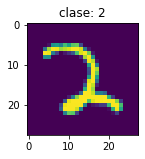

In [ ]:
# Tu código acá
import random
import matplotlib.pyplot as plt

index_example = random.randint(0, len(dataset))
T_example, l_example = dataset[index_example]

# Muestra de un ejemplo al azar
fig, axs = subplots(nrows=1, figsize=(2,1*3))
img = T_example.view(28,28).numpy()
plt.title('clase: ' + str(l_example))
plt.imshow(img)

FNN_test = FFNN(F=5, l_h=[32,16], l_a=[relu,relu], C=10, bias=0, W=[W1,W2], B=[b1,b2], U=U, C_pre_trained=C, device='cpu')
prediction = FNN_test.forward(T_example, predict=True)

print('Clase real: ' + str(l_example))
print('Clase predicha: ' +str(prediction.numpy()[0]))

## 3d) Pasando todos los ejemplos por la red con un `DataLoader`

In [ ]:
# Acá tu código

from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=100)

def calcula_acierto(red, dataset, batch_size=100, device='cuda'):
  network = red
  len_data = len(dataset)
  dataloader = DataLoader(dataset=dataset, batch_size=batch_size)
  accuracy = []
  if device == 'cuda':
    network.cuda()
  elif device == 'cpu':
    network.cpu()
  for x, y in dataloader:
    predictions = network.forward(x, predict=True)
    failed_pred = y - predictions
    accuracy_batch = torch.reshape((failed_pred == 0).sum(dim=0), (1,)).numpy()[0]
    accuracy.append(accuracy_batch)
  return sum(accuracy)/len_data

###Prueba CPU

In [ ]:
import time

time_i = time.time()

Network = FFNN(F=784, l_h =[32, 16], l_a=[relu, relu],C=10, bias=0, W=[W1,W2], B=[b1,b2], U=U, C_pre_trained=C, device='cpu')
Accuracy = calcula_acierto(red=Network, dataset=dataset, batch_size=10000, device='cpu')

time_f = time.time()
Time = time_f - time_i
print('Accuracy del sistema: ' + str(Accuracy))
print('Tiempo requerido: ' + str(Time))

Accuracy del sistema: 0.9612
Tiempo requerido: 0.6781997680664062


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


###Prueba GPU

In [ ]:
import time

time_i = time.time()

Network = FFNN(F=784, l_h =[32, 16], l_a=[relu, relu],C=10, bias=0, W=[W1,W2], B=[b1,b2], U=U, C_pre_trained=C, device='cuda')
Accuracy = calcula_acierto(red=Network, dataset=dataset, batch_size=10000, device='cuda')

time_f = time.time()
Time = time_f - time_i
print('Accuracy del sistema: ' + str(Accuracy))
print('Tiempo requerido: ' + str(Time))

Accuracy del sistema: 0.9612
Tiempo requerido: 0.6342356204986572


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


Al aumentar el tamaño del batch, entonces el sistema realiza una menor cantidad de iteraciones, por lo que el proceso se acelera. Ademas al variar a la GPU tambien se reduce la cantidad de tiempo requerido.

### Corrección red

In [ ]:
# Tests del API del curso
from torch.utils.data import Subset
indices = corrector.get_test_data(homework=1, question="network", test=1, token=token)
test_set = Subset(dataset, indices)

# Modelo con los parámetros pre-entrenados para MNIST
your_network = FFNN(F=784, l_h =[32, 16], l_a=[relu, relu],C=10, bias=0, W=[W1,W2], B=[b1,b2], U=U, C_pre_trained=C, device='cpu')

# Montar el `test_set` en un tensor de (N, 28*28) usando DataLoader
X = list(DataLoader(test_set, batch_size=len(test_set)))[0][0].view(-1, 28*28)

# Almacenar el resultado en un puro tensor de (N,1)
result = torch.argmax(your_network.forward(X), dim=1)

corrector.sumbit(homework=1, question="network", test=1, token=token, answer=result)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


Correct Test!


## 3e) Opcional: Muestra los casos en donde la red se equivoca

In [ ]:
# Acá tu código

## 3d) Opcional: Crea tus propios ejemplos de dígitos para clasificar

In [ ]:
# Acá tu código